In [2]:
t_vals = np.arange(lsm_img.min(),lsm_img.max())
print(t_vals)
mRNA_punta = np.zeros((np.shape(t_vals)[0],2))

[   2.    3.    4. ... 1096. 1097. 1098.]


In [3]:
# for idx,t in enumerate(t_vals):
#     mRNAs = blob_log(lsm_img, min_sigma = 1.1,max_sigma= 5,threshold=t)
#     mRNA_punta[idx][0] = np.shape(mRNAs)[0]
#     mRNA_punta[idx][1] = t

# with open('num_punctas.npy', 'wb') as f:
#     np.save(f,mRNA_punta)

In [4]:
num_puncta = np.load("num_punctas.npy", mmap_mode='r')
num_puncta1 = np.load("num_punctas1.npy", mmap_mode='r')

In [5]:
print(num_puncta)

[[4.207e+03 2.000e+00]
 [9.640e+02 3.000e+00]
 [9.040e+02 4.000e+00]
 ...
 [0.000e+00 1.096e+03]
 [0.000e+00 1.097e+03]
 [0.000e+00 1.098e+03]]


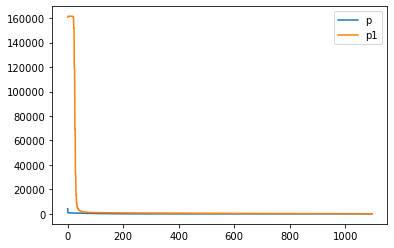

In [6]:
plt.plot(num_puncta[:,0],label="p")
plt.plot(num_puncta1[:,0],label="p1")
plt.legend()
# print(num_puncta[:][1])

In [7]:
folder = os.path.abspath(os.getcwd())+"/Gria1/"
f_type = "SUM"
roi_folder = "Rois/"
somas = ["Soma.zip","Soma.roi"]
dendrites = ["Dendrites.zip"]
neurons = ["RoiSet.zip"] 
Channel_names = {0:"Dapi",1:"Gria1",2:"MAP2",3:"CAMKII"}
scale = 4.81

In [8]:
print(folder)

/Users/surbhitwagle/Desktop/Surbhit/Work/PhD/2020/PhD/MPIBR/PhD-Project/Experimental_collab/Anne-Sophie/Gria1/


In [9]:
def isBetween(a,b,c):
# #     print("="*50)
# #     print(a,b,c)
#     crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])
#     epsilon = 1e-6
#     # compare versus epsilon for floating point values, or != 0 if using integers
#     if abs(crossproduct) > epsilon:
# #         print("cp")
#         return False

#     dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
#     if dotproduct < 0:
# #         print("dp")
#         return False

#     squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
#     if dotproduct > squaredlengthba:
# #         print("lp")
#         return False
# #     print("IB")
# #     print("="*50)
#     print("point in segment")
#     return True
    sides = np.zeros(3)
    sides[0] = (a[0]-b[0])**2 + (a[1]-b[1])**2  #ab
    original = sides[0]
    sides[1] = (b[0]-c[0])**2 + (b[1]-c[1])**2  #bc
    sides[2] = (c[0]-a[0])**2 + (c[1]-a[1])**2  #ca
    sides = np.sort(sides);
#     print(sides)
    if sides[2] > (sides[1] + sides[0]) and sides[2] != original:
#         print(c," not in section ",a,b)
        return False;
#     print("*"*20)
#     print(sides)
#     print("*"*20)
#     print(c," in section ",a,b)
    return True;
    
def Perpendicular_Distance_and_POI(a,b,c):
#     distance between two parallel lines, one passing (line1, A1 x + B1 y + C1 = 0) from a and b 
#     and second one (line 2, A1 x + B1 y + C2 = 0) parallel to line1 passing from c is given
#     |C1-C2|/sqrt(A1^2 + B1^2)
    m = (a[1]-b[1])/(a[0]-b[0]+1e-18)
    if m == 0:
        m = 1e-18
    c1 = a[1] - m*a[0]
    c2 = c[1] - m*c[0]
    dist = np.absolute(c1-c2)/np.sqrt(1+m**2)
    m_per = -1/m;
    c3 = c[1] - m_per*c[0]
    x_int = (c3 - c1)/(m-m_per)*1.0
    y_int = (m_per*x_int + c3)*1.0
    
    ax_int = np.sqrt((a[0]-x_int)**2 + (a[1]-y_int))
    bx_int = np.sqrt((b[0]-x_int)**2 + (b[1]-y_int))
    ab = np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
#     print("*"*20)
#     print("a = ",a,end="")
#     print("b = ",b,end="")
#     print("c = ",c,end="")
#     print("POI = ",(x_int,y_int))
#     print("ax_int + bx_int = ",ax_int+bx_int," ab = ",ab)
#     print(x_int,y_int,dist)
#     print("*"*20)
    return x_int,y_int,dist

def GetClosestRoiPoint(dendrite,point):
    min_dist = 10**18;
    prev = [dendrite[0][0],dendrite[1][0]]
    dist_from_origin = 0;
    closest_p = [0,0]
    closed_p_idx = 0
#     print(prev)
    for idx,x in enumerate(dendrite[0][:]):
        y = dendrite[1][idx]
        a = [x,y]
        dist = np.sqrt((point[1]-a[1])**2 + (point[0]-a[0])**2)
        if dist < min_dist:
            min_dist = dist
            dist_from_origin += np.sqrt((prev[1]-a[1])**2 + (prev[0]-a[0])**2)
            closest_p = a
            closed_p_idx = idx
        prev = a
#     print(closest_p, closed_p_idx)
    return dist_from_origin
#         b = [dendrite[0][idx+1],dendrite[1][idx+1]] 
        
def Is_On_Dendrite(dendrite_name,dendrite,point,max_dist):
    ## first check on which segment of the dendrite the point is present
#     print(dendrite)
#     mod_dendrite = np.delete(dendrite,2,0)
#     print(np.transpose(mod_dendrite))
#     xys = list(map(tuple, np.transpose(mod_dendrite)))
#     print(np.shape(np.transpose(mod_dendrite)))
    length_from_origin = 0
    prev_distance = 10**20
    for idx,x in enumerate(dendrite[0][:-1]):
#         x,y = p
        y = dendrite[1][idx]
#         print(x,y)
#     print()
        a = [x,y]
        b = [dendrite[0][idx+1],dendrite[1][idx+1]] 
        if isBetween(a,b,point):
            x_int,y_int,distance = Perpendicular_Distance_and_POI(a,b,point)
            if distance <= max_dist:
#                 prev_distance = distance
                length_from_origin += np.sqrt((y_int-a[1])**2 + (x_int-a[0])**2)
#                 print("point ",point," belong to dendrite ",dendrite_name," Distance is ", distance, " POI is ",(x_int,y_int))
                return True, length_from_origin/scale
        length_from_origin += np.sqrt((b[1]-a[1])**2 + (b[0]-a[0])**2)

    length_from_origin = GetClosestRoiPoint(dendrite,point)
    return False, length_from_origin/scale

In [38]:
def Extract_mRNA_Data(filename,channel):
#     fig, axes = plt.subplots(1,2, figsize=(20, 10), sharex=True, sharey=True)
#     ax = axes.ravel()

    orig_img = tf.imread(filename)
    orig_img = orig_img[channel]
#     orig_img = exposure.rescale_intensity(orig_img)
#     ax[0].imshow(orig_img)
#     ax[0].set_axis_off()
#     ax[1].set_axis_off()
#     ax[1].imshow(orig_img1)
#     plt.show()
#     orig_img = orig_img1
#     ax[0].imshow(orig_img)
#     plt.show()
    lsm_img = np.zeros(np.shape(orig_img),'uint8')
    correct_name = file.replace(f_type+"_","")
    correct_name = correct_name.replace(".tif","")
    correct_name = correct_name.replace(" ","_")
    soma_roi_zip_path = folder + roi_folder + correct_name + "/" + somas[0]
    file_exists = exists(soma_roi_zip_path)
    print(soma_roi_zip_path)
    dendrites_roi_zip_path = folder + roi_folder + correct_name + "/" + dendrites[0]
    #         print(os.path.isfile(soma_roi_zip_path))
    if not file_exists:
        soma_roi_zip_path =folder + roi_folder + correct_name + "/" + somas[1]
        soma_rois = read_roi_file(soma_roi_zip_path)
    else:
        soma_rois = read_roi_zip(soma_roi_zip_path)
    #         print(rois)
#     print(soma_rois)
    dendrite_rois = read_roi_zip(dendrites_roi_zip_path)
    #             prinzt(dendrite_rois)
    soma_polygons = {}
    dendrite_lines = {}
    soma_ps = {}
    soma_pxs = []
    anti_soma = np.ones(np.shape(orig_img),'uint8')
    somatic_puncta = {}
    dendritic_puncta = {}
#     soma_rois = {}
    soma_img = np.zeros(np.shape(orig_img),'uint8')
    
    for soma in ["Soma_001"]:
        sp = []
        lsm_img = np.zeros(np.shape(orig_img),'uint8')
        soma_instance = soma_rois[soma]
        print(soma_instance)
        soma_polygons[soma] = [soma_instance['x'],soma_instance['y']]
#     for soma in soma_polygons.keys():
#         poly = list(map(tuple, np.transpose(soma_polygons[soma])))
#         print(poly)
        rr, cc = polygon(soma_instance['y'], soma_instance['x'], lsm_img.shape)
#         soma_pxs = np.array(rr,cc)
        print(lsm_img.shape,np.shape(rr),np.shape(cc))
#         plotHistogram(orig_img[rr,cc])
        soma_ps[soma] = orig_img[rr,cc] 
        lsm_img[rr,cc] = 1
        anti_soma = np.multiply(anti_soma,1 - lsm_img)
#         print()
        print(np.quantile(soma_ps[soma],0.75))
        print(np.quantile(soma_ps[soma],0.25))
        print(np.quantile(soma_ps[soma],0.5))
        filtered_soma = orig_img[np.nonzero(lsm_img)]
        plotHistogram(filtered_soma)
        t = (np.quantile(filtered_soma,0.5))#+np.quantile(filtered_soma,0.25))/2.0
        soma_img = np.multiply(orig_img,lsm_img)
        blobs_log = blob_log(soma_img,threshold=t)
        blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    #     ax[0].imshow(img)
        count =0
#         puncta_stats
        for blob in blobs_log:
            y, x, r = blob
            i_x = int(x)
            i_y = int(y)
            count += 1;
#             sp.append([x,y,r])
    #         mod_t[i_y][i_x] = t[idx][i_y][i_x]
            c = plt.Circle((x, y), r, color='r', linewidth=1, fill=False)
            puncta_stats = [x,y,r]
            puncta_stats += GetPunctaStats(x,y,r,orig_img)
            puncta_stats += [True,0.0]
            sp.append(puncta_stats)
#             rr,cc = circle((x,y))
#             ax[1].add_patch(c)
        print(count)#,"\n",len(mod_t))
        somatic_puncta[soma] = sp 
#     ax[0].imshow(np.multiply(orig_img,1-anti_soma))
#     ax[0].set_axis_off()
#     ax[1].set_axis_off()
#     ax[1].imshow(np.multiply(orig_img,1-anti_soma))
#     plt.show()
    
    width = 10*scale
    dend_ps = []
    dilated = np.zeros(np.shape(orig_img),'uint8')
#     fig, [ax0,ax1] = plt.subplots(1,2, figsize=(20, 10), sharex=True, sharey=True)
#     anti_dend = np.ones(np.shape(orig_img),'uint8')
    for jdx,dendrite in enumerate(dendrite_rois.keys()):
        dendrite_img = np.zeros(np.shape(orig_img),'uint8')
        if jdx<1:
            count =0
            dendrite_instance = dendrite_rois[dendrite]
            dendrite_lines[dendrite] = []
            xs,ys,w = dendrite_instance['x'],dendrite_instance['y'],dendrite_instance['width']
    #                 print(list(dendrite_lines[dendrite]))
            for lk in range(0,len(xs)-1):
    #             print(dendrite_lines[dendrite][lk][0])
                rr, cc = line(ys[lk],xs[lk],ys[lk+1],xs[lk+1])
                dendrite_img[rr,cc] = 1
    #             dendrite_lines[dendrite].append([rr,cc])
            dilated = morphology.dilation(dendrite_img, morphology.disk(radius=width))
            dilated = np.multiply(anti_soma,dilated)
            anti_soma = np.multiply(anti_soma,1 - dilated)
            dend_img = np.multiply(dilated,orig_img)
            filtered_dend_img = dend_img[np.nonzero(dend_img)]
#             print(filte)
            
            print(dendrite + " ", np.quantile(filtered_dend_img,0.75))
            print(dendrite + " " , np.quantile(filtered_dend_img,0.25))
            print(dendrite + " " , np.quantile(filtered_dend_img,0.5))
            plotHistogram(filtered_dend_img)
            t = (np.quantile(filtered_dend_img,0.5))
            print("max = ",dend_img.max()," min = ",dend_img.min())
            dend_blobs_log = blob_log(dend_img, threshold=t)
            dend_blobs_log[:, 2] = dend_blobs_log[:, 2] * sqrt(2)
            dp = []
            for blob in dend_blobs_log:
                y, x, r = blob
                i_x = int(x)
                i_y = int(y)
                count += 1;
        #         mod_t[i_y][i_x] = t[idx][i_y][i_x]
                puncta_stats = [x,y,r]
                puncta_stats += GetPunctaStats(x,y,r,orig_img)
                on_dendrite, distance_from_origin = Is_On_Dendrite(dendrite,[xs,ys,w],[x,y],width)
                puncta_stats += [on_dendrite, distance_from_origin]
                dp.append(puncta_stats)
#                 print(on_dendrite, distance_from_origin)
                c = plt.Circle((x, y), r, color='b', linewidth=.5, fill=False)
#                 ax1.add_patch(c)
            print("found ",count, " mRNAs in ",dendrite)#,"\n",len(mod_t))
        dendritic_puncta[dendrite] = dp
#     ax0.imshow(anti_soma)
#     ax1.imshow(np.multiply(orig_img,1-anti_soma))#dend_img)
#     plt.show()
    print(somatic_puncta,"*"*20,dendritic_puncta)
    return somatic_puncta,dendritic_puncta

In [39]:
#set somatic = False for dendritic punctas
def GetPunctaStats(x,y,r,original_img):
    #claculates the stats of gaussian puncta centered at x,y with radius r
    img = np.zeros(original_img.shape, dtype=np.uint8)
    rr, cc = disk((y, x), r,shape=original_img.shape)
    img[rr, cc] = 1
    f_img = np.multiply(original_img,img)
    f_img_data = original_img[np.nonzero(f_img)]
    puncta_stats = [f_img_data.max(),f_img_data.min(),f_img_data.mean(),f_img_data.std(),np.median(f_img_data)]
#     print("punct stat: ",puncta_stats)
    return puncta_stats

In [40]:
def plotHistogram(x):
#     bd = np.arange(img.min(),img.max(),1)
# #     print(np.shape(img))
# #     print(np.shape(bd))
#     line_img = img_as_float(img);
# #     print(np.shape(line_img))
#     hi = np.histogram(line_img,bd)
#     print(hi[1][:])
# #     print(np.shape(hi[1]))
# #     print(np.shape(bd))
# #     h2= np.transpose(hi[1])
# #     print(len(h2),len(bd))
# #     m = np.matmul(h2,bd); 
# #     nm = np.sum(hi); 
# #     print(hi)
#     fig,axes = plt.subplots(1,1, figsize=(10, 10), sharex=True, sharey=True)
#     plt.plot(hi[0][:],bd[:-1])
#     plt.show()
#     img_gray = rgb2gray(img)
    
#     img = img.flatten()
#     binss = range(int(img.min()),int(img.max()),1)
#     ax = plt.hist(img.ravel(),bins=int(np.size(img)/2))
#     plt.xlim(190,250)
#     plt.ylim(0,10000)
    fig,ax = plt.subplots(1,1, figsize=(10, 10), sharex=True, sharey=True)
    q25, q75, q50 = np.percentile(x, [25, 75, 50])
    print(q25, q75)
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
    print("bin width = ",bin_width)
    bins = round((x.max() - x.min()) / bin_width)
    print(x.max(), x.min())
    print("Freedman–Diaconis number of bins:", bins)
    ax.hist(x, bins=bins,label = 'data');
    plt.axvline(x=q75, color = 'r', label = '75% quantile')
    plt.axvline(x=q25, color = 'g', label = '25% quantile')
    plt.axvline(x=q50, color = 'y', label = '50% quantile')
    plt.legend()
    plt.show()

**************************************************
Analysing for  SUM_gria1 as camkii exp01 c01.tif
/Users/surbhitwagle/Desktop/Surbhit/Work/PhD/2020/PhD/MPIBR/PhD-Project/Experimental_collab/Anne-Sophie/Gria1/SUM/SUM_gria1 as camkii exp01 c01.tif
/Users/surbhitwagle/Desktop/Surbhit/Work/PhD/2020/PhD/MPIBR/PhD-Project/Experimental_collab/Anne-Sophie/Gria1/Rois/gria1_as_camkii_exp01_c01/Soma.zip
{'type': 'polygon', 'x': [452, 424, 400, 360, 332, 300, 284, 282, 294, 308, 340, 374, 404, 420, 444, 458], 'y': [700, 702, 702, 700, 698, 702, 718, 740, 772, 788, 796, 792, 788, 770, 752, 728], 'n': 16, 'width': 0, 'name': 'Soma_001', 'position': 3}
(1024, 1024) (13572,) (13572,)
63.0
14.0
26.0
14.0 63.0
bin width =  4.10845112960137
808.0 4.0
Freedman–Diaconis number of bins: 196


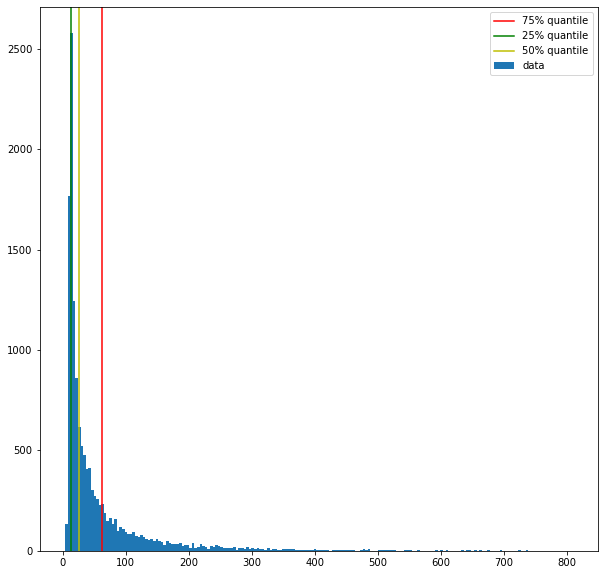

96
Primary_75_001_s001  12.0
Primary_75_001_s001  9.0
Primary_75_001_s001  11.0
9.0 12.0
bin width =  0.173587624595902
307.0 2.0
Freedman–Diaconis number of bins: 1757


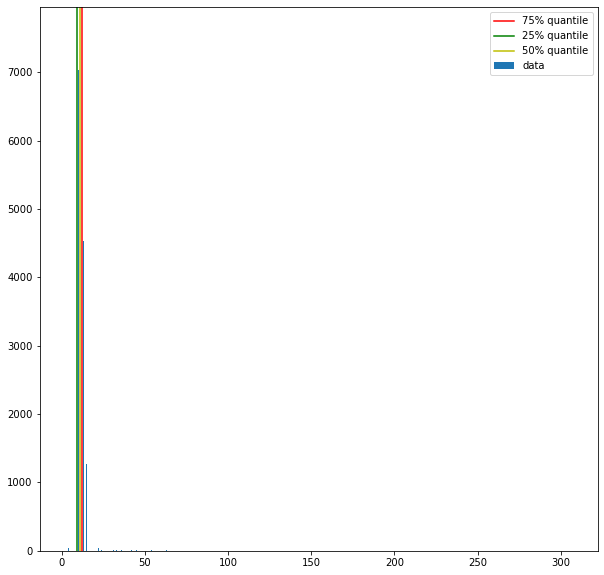

max =  307.0  min =  0.0
found  12  mRNAs in  Primary_75_001_s001
{'Soma_001': [[352.0, 748.0, 1.4142135623730951, 808.0, 398.0, 587.6667, 136.34842, 572.0, True, 0.0], [370.0, 775.0, 1.4142135623730951, 564.0, 252.0, 415.33334, 97.56707, 412.0, True, 0.0], [369.0, 748.0, 1.4142135623730951, 738.0, 599.0, 661.8889, 42.120052, 674.0, True, 0.0], [386.0, 747.0, 1.4142135623730951, 546.0, 259.0, 401.44446, 85.9911, 417.0, True, 0.0], [319.0, 717.0, 1.4142135623730951, 476.0, 172.0, 314.8889, 89.48053, 328.0, True, 0.0], [345.0, 721.0, 1.4142135623730951, 532.0, 264.0, 406.8889, 86.7659, 422.0, True, 0.0], [422.0, 747.0, 1.4142135623730951, 462.0, 143.0, 278.22223, 91.358604, 299.0, True, 0.0], [358.0, 755.0, 1.4142135623730951, 565.0, 312.0, 419.33334, 80.89774, 420.0, True, 0.0], [368.0, 756.0, 1.4142135623730951, 481.0, 178.0, 322.1111, 85.84281, 329.0, True, 0.0], [360.0, 750.0, 1.4142135623730951, 524.0, 253.0, 398.77777, 104.90395, 349.0, True, 0.0], [298.0, 762.0, 1.4142135623730951

TypeError: Object of type float32 is not JSON serializable

In [41]:
somatic_punctas = {}
soma_polygons = {}
somatic_mRNA = []
non_somatic_mRNA = []
dendrite_lines = {}
lsm_img = []
dendritic_punctas = {}
non_dendritic_punctas = {}
for idx,file in enumerate(os.listdir(folder+f_type+"/")):
    if file.endswith(".tif") and "exp01 c01" in file:
        print("*"*50)
        print("Analysing for ",file)
        fname = folder+f_type+"/"+file
        print(fname)
        # for jdx,dendrite in enumerate(dendrite_lines.keys()):
#     print(dendrite," ",dendrite_lines[dendrite])
        channels = [1];
        #seperating somatic vs non-somatic punctas
#         somatic_punctas,soma_polygons, somatic_mRNA, non_somatic_mRNA,dendrite_lines,lsm_img = Extract_mRNA_Data(fname,channel)
        dendrite_width = 15
        for channel in channels:
            somatic_punctas,dendritic_punctas = Extract_mRNA_Data(fname,channel)
            path_to_op = folder+f_type+"/"+file.split(".")[0]+"/"+Channel_names[channel]+"/"+str(dendrite_width)+"/"
            Path(path_to_op).mkdir(parents=True, exist_ok=True)
            soma_op = path_to_op+"Soma_mRNA"+Channel_names[channel];
            dendrite_op = path_to_op+"Dendrite_mRNA"+Channel_names[channel];
            with open(soma_op+".json", 'w') as f:
                json.dump(somatic_punctas, f,sort_keys=True, indent=4)
            with open(dendrite_op+".json", 'w') as f:
                json.dump(dendritic_punctas, f,sort_keys=True, indent=4)
            

In [ ]:
somatic_punctas = {}
soma_polygons = {}
somatic_mRNA = []
non_somatic_mRNA = []
dendrite_lines = {}
lsm_img = []
dendritic_punctas = {}
non_dendritic_punctas = {}
count = 1;
for idx,file in enumerate(os.listdir(folder+"/cell_1")):
    if file.endswith(".lsm"):
        lsm_filename = file
        
#         path_to_op = folder+"cell_"+str(count)+"/";
#         print(path_to_op,file)
#         count = count + 1;
#         Path(path_to_op).mkdir(parents=True, exist_ok=True)
#         copyfile(folder+"/"+file, path_to_op+"/"+file)
#         print("*"*50)
#         print("Analysing for ",file)
#         fname = folder+f_type+"/"+file
#         print(fname)
#         # for jdx,dendrite in enumerate(dendrite_lines.keys()):
# #     print(dendrite," ",dendrite_lines[dendrite])
#         channels = [1,3];
#         #seperating somatic vs non-somatic punctas
# #         somatic_punctas,soma_polygons, somatic_mRNA, non_somatic_mRNA,dendrite_lines,lsm_img = Extract_mRNA_Data(fname,channel)
#         dendrite_width = 15
#         for channel in channels:
#             somatic_punctas,dendritic_punctas = Extract_mRNA_Data(fname,channel)
#             path_to_op = folder+f_type+"/"+file.split(".")[0]+"/"+Channel_names[channel]+"/"+str(dendrite_width)+"/"
#             Path(path_to_op).mkdir(parents=True, exist_ok=True)
#             soma_op = path_to_op+"Soma_mRNA"+Channel_names[channel];
#             dendrite_op = path_to_op+"Dendrite_mRNA"+Channel_names[channel];
#             with open(soma_op+".json", 'w') as f:
#                 json.dump(somatic_punctas, f,sort_keys=True, indent=4)
#             with open(dendrite_op+".json", 'w') as f:
#                 json.dump(dendritic_punctas, f,sort_keys=True, indent=4)
#         print(file)
            

In [ ]:
# plt.imshow(lsm_img)


In [ ]:
r = np.random.rand(40000).reshape((200, 200))
sort_r = np.sort(r,axis =0)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(r)
ax1.plot(sort_r)
plt.show()